In [ ]:
! pip install clockify  # clockify-api-client has some problems with getting all time entries
! pip install clockify-api-client  # clockify has some problems with projects
! pip install matplotlib==3.4.2

from google.colab import drive
from datetime import datetime
from dateutil import parser
from clockify import factories
from clockify_api_client.client import ClockifyAPIClient
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import logging

drive.mount('/content/drive/')

In [ ]:
# Helper functions
def match(done_project, done_task, target_task):
  target_task = str(target_task).strip().lower()
  if target_task.startswith('project:'):
    target_project = target_task[8:].strip()
    done_project = str(done_project).lower()
    return done_project == target_project
  elif target_task.startswith('task:'):
    target_desc = target_task[5:].strip()
    done_task = str(done_task).lower()
    return target_desc in done_task
  else:
    raise 'Unknown task description!'

def process_entry(done, task=None):
  elapsed = 0
  duration = done['timeInterval']['duration']
  r = re.match(r"PT(\d*H)?(\d*M)?(\d*S)?", duration)
  if r.group(1):
    elapsed += int(r.group(1)[:-1])
  if r.group(2):
    elapsed += int(r.group(2)[:-1])/60
  if r.group(3):
    elapsed += int(r.group(3)[:-1])/3600
  
  if (task is None) or match(projects[done['projectId']], done['description'], task['Description']):
    return elapsed
  return 0

In [ ]:
### Parameters ###

start_of_sprint = 1643401800  # start of the sprint (Unix epoch time to avoid timezone problems)
sprint_days = 14
total_sprint_time = 80  # Estimated hours to be used to track off-schedule spent times.
end_of_sprint = start_of_sprint + sprint_days * 86400

# Excel file including tasks 
file_path = '/content/drive/My Drive/Planning/Tasks.xlsx'
sheet_name = 'Sprint1'

# clockify api key
api_key = '<API KEY>'  # Find it in https://clockify.me/user/settings
workspace_name = ''  # name of the workspace in clockify (leave it blank if you have just one workspace) 
user_name = '' # Leave it blank if you are the only user

INFO:root:Start function: get_all_workspaces
INFO:root:Start function: get_all_workspace_users
INFO:root:Start function: get_all_time_entry_user


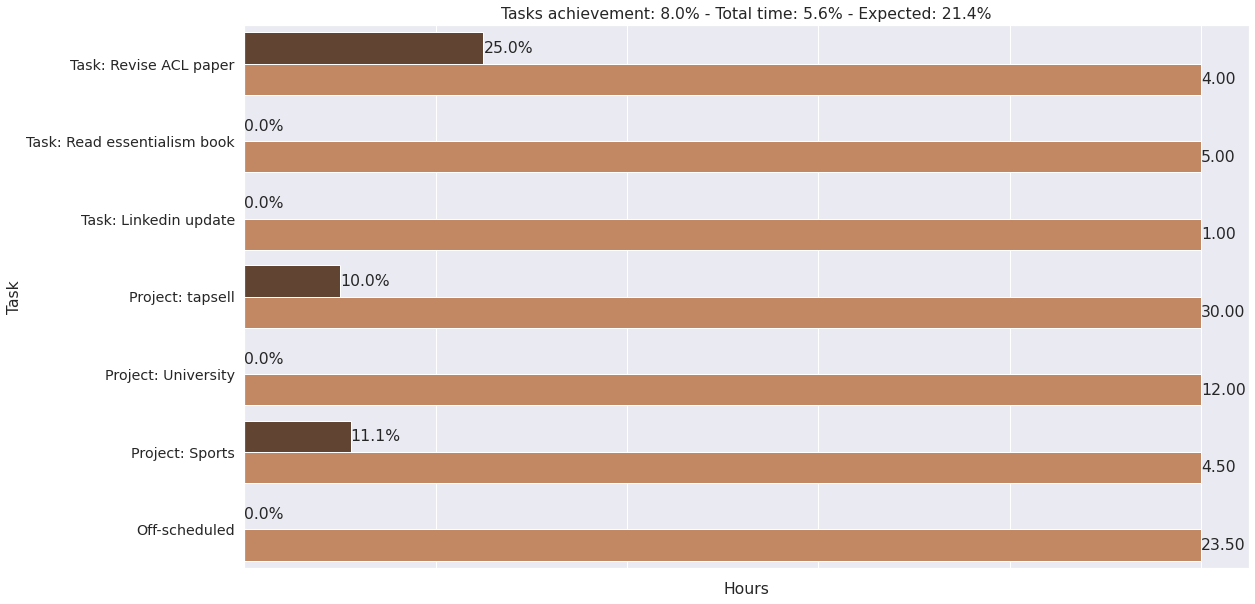

In [4]:
# Obtain user_id
for workspace in factories.Workspace(api_key=api_key).get_all_workspaces():
  if (workspace['name'] == workspace_name) or (workspace_name == ''):
    workspace_id = workspace['id']

# obtain workspace_id
for user in factories.User(api_key=api_key).get_all_workspace_users(workspace_id=workspace_id):
  if (user['name'] == user_name) or (user_name == ''):
    user_id = user['id']

# Obtain project_ids
client = ClockifyAPIClient().build(api_key, 'api.clockify.me/v1')
projects = dict()
for project in client.projects.get_projects(workspace_id):
  if not project['archived']:
    projects[project['id']] = project['name']

# Read tasks
# sort to place tasks above projects (to avoid double calculation of clockify entries which match both a project and a task)
tasks = pd.read_excel(file_path, sheet_name=sheet_name).sort_values('Description', ascending=False).reset_index(drop=True)  
total_scheduled_hours = np.sum(tasks['Estimated Hours'])

# Process time entries
results = [[0.0, float(d['Estimated Hours']), d['Description']] for i,d in tasks.iterrows()]  # (spend_hours, estimated_hours)

processed_ids = [] # get_all_time_entry_user returns each entry multiple times, so we need to check them. 
off_schedule_spent = 0
for entry in factories.TimeEntry(api_key=api_key).get_all_time_entry_user(workspace_id=workspace_id, user_id=user_id):
  date = parser.parse(entry['timeInterval']['start']).timestamp()
  if (start_of_sprint <= date < end_of_sprint) and (entry['id'] not in processed_ids):
    entry_matched = False
    processed_ids.append(entry['id'])
    for i, t in tasks.iterrows():
      elapsed_time = process_entry(entry, t)
      results[i][0] += elapsed_time
      if elapsed_time > 0:
          entry_matched = True
          break
    if not entry_matched:
      off_schedule_spent += process_entry(entry)

results.append([off_schedule_spent, total_sprint_time-total_scheduled_hours, 'Off-scheduled'])

# Normalize and plot results
df = []
for r in results:
  df.append(['Spent', r[0]/r[1], r[0], r[2]])
  df.append(['Estimated', 1, r[1], r[2]])
df = pd.DataFrame(df, columns=['Type', 'Hours-Rate', 'Hours-Val', 'Task'])

sns.set(rc={'figure.figsize':(18,10)}, font_scale=1.3)
g = sns.barplot(x="Hours-Rate", y="Task",
            hue="Type", data=df, palette='copper')
g.legend_ = None
g.set(xticklabels=[])
g.set(xlabel='Hours')
total_spent_hours_tasks = np.sum([min(r[0],r[1]) for r in results[:-1]])  # Just scheduled tasks. Times spent more than scheduled not considered
total_spent_hours = np.sum([r[0] for r in results])
g.set(title=f"Tasks achievement: {total_spent_hours_tasks/total_scheduled_hours*100:.1f}% - " + 
            f"Total time: {total_spent_hours/total_sprint_time*100:.1f}% - " + 
            f"Expected: {(datetime.now().timestamp()-start_of_sprint)/(sprint_days*86400)*100:.1f}%")

for i, container in enumerate(g.containers):
  if i == 0:  # spent
    g.bar_label(container, [f"{r[0]/r[1]*100:.1f}%" for r in results])
  else:  # estimated
    g.bar_label(container, [f"{r[1]:.2f}" for r in results])